In [1]:
!pip install optuna
!pip install pytorch-lightning
!pip install pytorch-forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 5.3 MB/s 
     |████████████████████████████████| 209 kB 54.6 MB/s 
     |████████████████████████████████| 81 kB 3.8 MB/s 
     |████████████████████████████████| 78 kB 3.1 MB/s 
     |████████████████████████████████| 112 kB 46.9 MB/s 
     |████████████████████████████████| 49 kB 6.0 MB/s 
     |████████████████████████████████| 146 kB 48.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=3c319cbf8f892bc9d6547156ffe952a29f05c34c21288b340ac2415ac0b96bb8
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 5.2 MB/s 
     |████████████████████████████████| 418 kB 53.4 MB

In [2]:
import os
import warnings
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import optuna

from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from sklearn.preprocessing import MinMaxScaler


import torch
import torch.nn.functional as F
from torch import distributions

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting.data.examples import generate_ar_data

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE, DistributionLoss, NormalDistributionLoss, LogNormalDistributionLoss, BaseEstimator
from pytorch_forecasting.data.encoders import GroupNormalizer

warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


In [3]:
class MultivariateDistributionLoss(DistributionLoss):
    """Base class for multivariate distribution losses.

    Class should be inherited for all multivariate distribution losses, i.e. if a batch of values
    is predicted in one go and the batch dimension is not independent, but the time dimension still
    remains independent.
    """

    def sample(self, y_pred, n_samples: int) -> torch.Tensor:
        """
        Sample from distribution.

        Args:
            y_pred: prediction output of network (shape batch_size x n_timesteps x n_paramters)
            n_samples (int): number of samples to draw

        Returns:
            torch.Tensor: tensor with samples  (shape batch_size x n_timesteps x n_samples)
        """
        dist = self.map_x_to_distribution(y_pred)
        samples = dist.sample((n_samples,)).permute(
            2, 1, 0
        )  # returned as (n_samples, n_timesteps, batch_size), so reshape to (batch_size, n_timesteps, n_samples)
        return samples


    def to_prediction(self, y_pred: torch.Tensor) -> torch.Tensor:
        """
        Convert network prediction into a point prediction.

        Args:
            y_pred: prediction output of network

        Returns:
            torch.Tensor: mean prediction
        """
        distribution = self.map_x_to_distribution(y_pred)

        return distribution.mean.transpose(0, 1)  # switch to batch_size x n_timesteps


    def loss(self, y_pred: torch.Tensor, y_actual: torch.Tensor) -> torch.Tensor:
        """
        Calculate negative likelihood

        Args:
            y_pred: network output
            y_actual: actual values

        Returns:
            torch.Tensor: metric value on which backpropagation can be applied
        """
        distribution = self.map_x_to_distribution(y_pred)
        # calculate one number and scale with batch size
        loss = -distribution.log_prob(y_actual.transpose(0, 1)).sum() * y_actual.size(0)
        return loss

In [4]:
class MultivariateNormalDistributionLoss(MultivariateDistributionLoss):
    """
    Multivariate low-rank normal distribution loss.

    Use this loss to make out of a DeepAR model a DeepVAR network.

    Requirements for original target normalizer:
        * not normalized in log space (use :py:class:`~LogNormalDistributionLoss`)
        * not coerced to be positive
    """

    distribution_class = distributions.LowRankMultivariateNormal

    def __init__(
        self,
        name: str = None,
        quantiles: List[float] = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98],
        reduction: str = "mean",
        rank: int = 10,
        sigma_init: float = 1.0,
        sigma_minimum: float = 1e-3,
    ):
        """
        Initialize metric

        Args:
            name (str): metric name. Defaults to class name.
            quantiles (List[float], optional): quantiles for probability range.
                Defaults to [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98].
            reduction (str, optional): Reduction, "none", "mean" or "sqrt-mean". Defaults to "mean".
            rank (int): rank of low-rank approximation for covariance matrix. Defaults to 10.
            sigma_init (float, optional): default value for diagonal covariance. Defaults to 1.0.
            sigma_minimum (float, optional): minimum value for diagonal covariance. Defaults to 1e-3.
        """
        super().__init__(name=name, quantiles=quantiles, reduction=reduction)
        self.rank = rank
        self.sigma_minimum = sigma_minimum
        self.sigma_init = sigma_init
        self.distribution_arguments = list(range(2 + rank))

        # determine bias
        self._diag_bias: float = self.inv_softplus(self.sigma_init**2) if self.sigma_init > 0.0 else 0.0

    def map_x_to_distribution(self, x: torch.Tensor) -> distributions.Normal:
        x = x.permute(1, 0, 2)
        return self.distribution_class(
            loc=x[..., 0],
            cov_factor=x[..., 2:],
            cov_diag=x[..., 1],
        )


    @staticmethod
    def validate_encoder(encoder: BaseEstimator):
        assert encoder.transformation not in [
            "log",
            "log1p",
        ], "Use MultivariateLogNormalDistributionLoss for log scaled data"  # todo: implement
        assert encoder.transformation not in [
            "softplus",
            "relu",
        ], "Cannot use NormalDistributionLoss for positive data"
        assert encoder.transformation not in ["logit"], "Cannot use bound transformation such as 'logit'"

    def rescale_parameters(
        self, parameters: torch.Tensor, target_scale: torch.Tensor, encoder: BaseEstimator
    ) -> torch.Tensor:
#         self.validate_encoder(encoder)

        # scale
        loc = encoder(dict(prediction=parameters[..., 0], target_scale=target_scale)).unsqueeze(-1)
        scale = (
            F.softplus(parameters[..., 1].unsqueeze(-1) + self._diag_bias) + self.sigma_minimum**2
        ) * target_scale[..., 1, None, None] ** 2

        cov_factor = parameters[..., 2:] * target_scale[..., 1, None, None]
        return torch.concat([loc, scale, cov_factor], dim=-1)


    def inv_softplus(self, y):
        if y < 20.0:
            return np.log(np.exp(y) - 1.0)
        else:
            return y

In [5]:
with open('/content/drive/MyDrive/Colab Notebooks/실무인증/Data/crypto_currency_data_v1.pickle', 'rb') as f:
    data = pickle.load(f)

drop_col = ['휘발유', '고급휘발유', '경유', '가스오일', '난방유', '천연가스', '옥수수', '설탕', '대두', '대두박', '대두유', '면화', '소맥', '쌀',
            '오렌지주스', '커피', '코코아','CD금리(91일)', '콜금리(1일)', '국고채(3년)', '회사채(3년)', 'COFIX잔액', 'COFIX신규취급액', 'timestamp' ]
# data_col = ['market', 'candle_acc_trade_volume', 'time_index', 'date', 'trade_price']
res_data = data.drop(drop_col, axis=1)
res_data['date'] = pd.to_datetime(res_data['date'], format='%Y-%m-%d')
res_data = res_data.sort_values('date').reset_index(drop=True)
res_data['market'] = 'ETH-KRW'
res_data['time_index'] = np.arange(len(data))
res_data['time_index'] = res_data['time_index'].astype(int)

# GroupNormalizer
gn = GroupNormalizer(
    groups= ['market'],
    scale_by_group = True
)

res_data_columns = res_data.drop(columns=['date','market', 'time_index'], axis=1).columns
for n, i in enumerate(res_data_columns):
    # if n < 3:
    # print(i)
    globals()['scaled_{}'.format(i)] = gn.fit_transform(res_data[i], res_data, return_norm = True)
    res_data[i] = globals()['scaled_{}'.format(i)][0]


In [62]:
def objective(trial):

    cfg = {'device' : "cuda" if torch.cuda.is_available() else "cpu",
            'batch_size' : trial.suggest_categorical('batch_size', [16,32,64,128,256,512,1024]), 
            'seed' : 42, 
            'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
            'log_interval' : trial.suggest_int('log_interval', 10, 51, 10),
            'log_val_interval': trial.suggest_int('log_val_interval', 1, 11, 1),
            'hidden_size' : trial.suggest_categorical('hidden_size', [16,32,64,128,256,512,1024]),
            'dropout' : trial.suggest_int('dropout', 0.1, 0.4, 0.1),
            'rnn_layers' : trial.suggest_int('rnn_layers',1, 1),
            'max_epochs' : trial.suggest_int('max_epochs', 10, 110, 100), 
            'limit_train_batches' : trial.suggest_int('limit_train_batches', 10, 110, 10),
            'gpus' : trial.suggest_int('gpus', -1, 2, 1),
            'gradient_clip_val' : trial.suggest_loguniform('gradient_clip_val', 1e-4, 0.1)
            } 

    torch.manual_seed(cfg['seed']) 

    # create dataset and dataloader
    max_encoder_length = 60
    max_prediction_length = 20

    training_cutoff = res_data['time_index'].max() - max_prediction_length


    training = TimeSeriesDataSet(
        res_data[lambda x: x.time_index <= training_cutoff],
        time_idx="time_index",
        target="trade_price",
        categorical_encoders={"market": NaNLabelEncoder().fit(res_data.market)},
        group_ids=["market"],
        min_encoder_length=max_encoder_length,
        max_encoder_length=max_encoder_length,
        min_prediction_length=max_prediction_length,
        max_prediction_length=max_prediction_length,
        time_varying_unknown_reals= ["trade_price"], 
        time_varying_known_reals=["time_index"],
        add_relative_time_idx=False,
        add_target_scales=True,
        randomize_length=None,
    )

    validation = TimeSeriesDataSet.from_dataset(
        training,
        res_data,
        min_prediction_idx = training_cutoff + 1,
        # stop_randomization=True
    )

    batch_size = cfg['batch_size']
    train_dataloader = training.to_dataloader(train = True, batch_size = batch_size, num_workers = 0)
    val_dataloader = validation.to_dataloader(train = False, batch_size = batch_size, num_workers = 0)

    net = DeepAR.from_dataset(
        training, 
        learning_rate=cfg['learning_rate'],
        log_interval=cfg['log_interval'],
        log_val_interval=cfg['log_val_interval'],
        hidden_size=cfg['hidden_size'],
        dropout=cfg['dropout'],
        rnn_layers=cfg['rnn_layers'],
        loss= MultivariateNormalDistributionLoss()
    )

    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=True, mode="min")
    lr_logger = LearningRateMonitor()

    trainer = pl.Trainer(
        max_epochs = cfg['max_epochs'],
        gpus = cfg['gpus'],
        weights_summary = 'top',
        gradient_clip_val = cfg['gradient_clip_val'],
        callbacks = [lr_logger, early_stop_callback],
        limit_train_batches =  cfg['limit_train_batches'],
        enable_checkpointing = True,
        auto_lr_find = True,
        logger = TensorBoardLogger('./lightning_logs/deepAR')
    )

    print(f"Number of parameters in network: {net.size()/1e3:.1f}k")

    trainer.fit(
        net,
        train_dataloaders = train_dataloader,
        val_dataloaders = val_dataloader,
    )

    best_model_path = trainer.checkpoint_callback.best_model_path
    best_model = DeepAR.load_from_checkpoint(best_model_path)

    actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
    predictions, _ = best_model.predict(val_dataloader, return_x=True, n_samples=100)

    SMAPE = (2 * (predictions - actuals).abs() / (predictions.abs() + actuals.abs() + 1e-8)).mean()

    # (actuals - predictions).abs().mean()

    return SMAPE

In [63]:
# # save datasets
# training.save("training.pkl")
# validation.save("validation.pkl")

In [64]:
sampler = optuna.samplers.TPESampler() 

study = optuna.create_study(sampler=sampler, direction='minimize') 
study.optimize(objective, n_trials=1) 
joblib.dump(study, '/content/deepar_optuna.pkl')

[I 2022-06-03 17:33:54,168] A new study created in memory with name: no-name-333a9935-8c19-469f-b3b4-a4041e057fb7
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 0     
3 | rnn                    | LSTM                               | 17.9 K
4 | distribution_projector | Linear                             | 780   
------------------------------------------------------------------------------
18.7 K    Trainable params
0         Non-trainable params
18.7 K    Total params
0.075     Total estim

Number of parameters in network: 18.7k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 3.341


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.978 >= min_delta = 0.1. New best score: 1.363


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.364 >= min_delta = 0.1. New best score: 0.999


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.307 >= min_delta = 0.1. New best score: 0.692


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.183 >= min_delta = 0.1. New best score: 0.509


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.174 >= min_delta = 0.1. New best score: 0.335


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.182 >= min_delta = 0.1. New best score: 0.153


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.236 >= min_delta = 0.1. New best score: -0.083


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.195 >= min_delta = 0.1. New best score: -0.278


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.144 >= min_delta = 0.1. New best score: -0.422


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.154 >= min_delta = 0.1. New best score: -0.576


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.388 >= min_delta = 0.1. New best score: -0.964


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.108 >= min_delta = 0.1. New best score: -1.072


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: -1.072. Signaling Trainer to stop.
[I 2022-06-03 17:36:11,401] Trial 0 finished with value: 0.560612678527832 and parameters: {'batch_size': 16, 'lr': 0.004910050380040648, 'log_interval': 20, 'log_val_interval': 7, 'hidden_size': 64, 'dropout': 0, 'rnn_layers': 1, 'max_epochs': 110, 'limit_train_batches': 110, 'gpus': -1, 'gradient_clip_val': 0.0027138577166795686}. Best is trial 0 with value: 0.560612678527832.


1
2
3
4
tensor([[1.1538, 1.1948, 1.2923, 1.3689, 1.3829, 1.4020, 1.4569, 1.4985, 1.5383,
         1.5453, 1.5741, 1.5741, 1.5896, 1.6180, 1.6407, 1.6340, 1.6308, 1.6518,
         1.6619, 1.6940]])
5


['/content/deepar_optuna.pkl']

In [65]:
study.best_params

{'batch_size': 16,
 'dropout': 0,
 'gpus': -1,
 'gradient_clip_val': 0.0027138577166795686,
 'hidden_size': 64,
 'limit_train_batches': 110,
 'log_interval': 20,
 'log_val_interval': 7,
 'lr': 0.004910050380040648,
 'max_epochs': 110,
 'rnn_layers': 1}

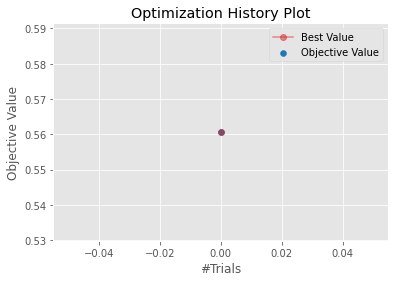

In [66]:
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

In [67]:
print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  1
Best trial:
  Value:  0.560612678527832
  Params: 
    batch_size: 16
    lr: 0.004910050380040648
    log_interval: 20
    log_val_interval: 7
    hidden_size: 64
    dropout: 0
    rnn_layers: 1
    max_epochs: 110
    limit_train_batches: 110
    gpus: -1
    gradient_clip_val: 0.0027138577166795686


In [69]:
torch.manual_seed(42) 

# create dataset and dataloader
max_encoder_length = 60
max_prediction_length = 20

training_cutoff = res_data['time_index'].max() - max_prediction_length


training = TimeSeriesDataSet(
    res_data[lambda x: x.time_index <= training_cutoff],
    time_idx="time_index",
    target="trade_price",
    categorical_encoders={"market": NaNLabelEncoder().fit(res_data.market)},
    group_ids=["market"],
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals= ["trade_price"], 
    time_varying_known_reals=["time_index"],
    add_relative_time_idx=False,
    add_target_scales=True,
    randomize_length=None,
)

validation = TimeSeriesDataSet.from_dataset(
    training,
    res_data,
    min_prediction_idx = training_cutoff + 1,
    # stop_randomization=True
)

batch_size = study.best_params['batch_size']
train_dataloader = training.to_dataloader(train = True, batch_size = batch_size, num_workers = 0)
val_dataloader = validation.to_dataloader(train = False, batch_size = batch_size, num_workers = 0)

net = DeepAR.from_dataset(
    training, 
    learning_rate=study.best_params['learning_rate'],
    log_interval=study.best_params['log_interval'],
    log_val_interval=study.best_params['log_val_interval'],
    hidden_size=study.best_params['hidden_size'],
    dropout=study.best_params['dropout'],
    rnn_layers=study.best_params['rnn_layers'],
    loss= MultivariateNormalDistributionLoss()
)

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=True, mode="min")
lr_logger = LearningRateMonitor()

trainer = pl.Trainer(
    max_epochs = study.best_params['max_epochs'],
    gpus = study.best_params['gpus'],
    weights_summary = 'top',
    gradient_clip_val = study.best_params['gradient_clip_val'],
    callbacks = [lr_logger, early_stop_callback],
    limit_train_batches =  study.best_params['limit_train_batches'],
    enable_checkpointing = True,
    auto_lr_find = True,
    logger = TensorBoardLogger('./lightning_logs/deepAR')
)

print(f"Number of parameters in network: {net.size()/1e3:.1f}k")

trainer.fit(
    net,
    train_dataloaders = train_dataloader,
    val_dataloaders = val_dataloader,
)

best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions, _ = best_model.predict(val_dataloader, return_x=True, n_samples=100)

print(f'MAE : {(actuals - predictions).abs().mean()}')

SMAPE = 2 * (predictions - actuals).abs() / (predictions.abs() + actuals.abs() + 1e-8).mean()
print(f'SMAPE : {SMAPE}')

plt.figure(figsize=(4, 3))
plt.plot(predictions[0], label='prediction')
plt.plot(actuals[0], label='actual')
plt.suptitle('Timeseries Prediction')
plt.legend()
plt.show()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 0     
3 | rnn                    | LSTM                               | 17.9 K
4 | distribution_projector | Linear                             | 780   
------------------------------------------------------------------------------
18.7 K    Trainable params
0         Non-trainable params
18.7 K    Total params
0.075     Total estimated model params size (MB)


Number of parameters in network: 18.7k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 3.341


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.978 >= min_delta = 0.0001. New best score: 1.363


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.057 >= min_delta = 0.0001. New best score: 1.306


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.307 >= min_delta = 0.0001. New best score: 0.999


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.307 >= min_delta = 0.0001. New best score: 0.692


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.183 >= min_delta = 0.0001. New best score: 0.509


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.174 >= min_delta = 0.0001. New best score: 0.335


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.182 >= min_delta = 0.0001. New best score: 0.153


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.236 >= min_delta = 0.0001. New best score: -0.083


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.195 >= min_delta = 0.0001. New best score: -0.278


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.144 >= min_delta = 0.0001. New best score: -0.422


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.154 >= min_delta = 0.0001. New best score: -0.576


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.073 >= min_delta = 0.0001. New best score: -0.649


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.314 >= min_delta = 0.0001. New best score: -0.964


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.108 >= min_delta = 0.0001. New best score: -1.072


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.049 >= min_delta = 0.0001. New best score: -1.120


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: -1.120. Signaling Trainer to stop.


MAE : 0.587518036365509
SMAPE : tensor([[0.0131, 0.1304, 0.3528, 0.3411, 0.3253, 0.2927, 0.4013, 0.4042, 0.6051,
         0.5317, 0.5904, 0.5920, 0.5479, 0.6100, 0.6340, 0.6541, 0.7996, 0.8683,
         0.8175, 0.8176]])


In [ ]:
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
)
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True, n_samples=100)
# for idx in range(2):  # plot 10 examples
for i in range(10):
    best_model.plot_prediction(x, raw_predictions, idx=i, add_loss_to_title=True)

AssertionError: ignored

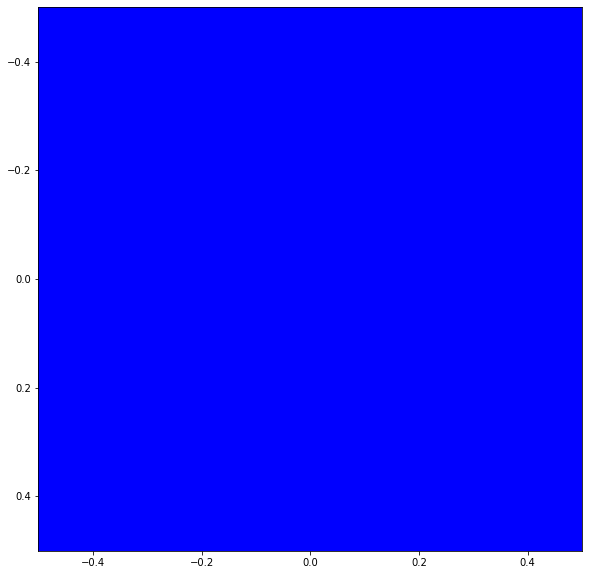

In [ ]:
cov_matrix = net.loss.map_x_to_distribution(
    net.predict(val_dataloader, mode=("raw", "prediction"), n_samples=None)
).covariance_matrix.mean(0)

# normalize the covariance matrix diagnoal to 1.0
correlation_matrix = cov_matrix / torch.sqrt(torch.diag(cov_matrix) * torch.diag(cov_matrix).T)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(correlation_matrix, cmap="bwr");